In [1]:
import integrator
import numpy as np
import numba
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os

## e=0.9 Example

In [2]:
# Next we want to test the orbital properties of an e = 0.9 Kepplerian orbit
e = 0.9
rp = 1.9
vt = 0.005927
period = 243
m1 = 1e2*6.67430e-11/0.8962419740798497
m2 = 1e7*6.67430e-11/0.8962419740798497
rcm = m1*rp/(m1+m2)
vcm = vt/rp*rcm

# For plotting the correct orbit
a = rp*(1-e)/(1-e**2)

part_pos = np.array([[rp,0,0],[0,0,0]],dtype=np.float64)
part_vel = np.array([[0,vt-vcm,0],[0,-vcm,0]],dtype=np.float64)
part_mass = np.array([m1,m2],dtype=np.float64)
dt = period/2010.6
num_dt = int(period/dt*200)
t = np.linspace(0,num_dt*dt,num_dt+1)
save_pos = np.zeros((num_dt+1,2,3))
save_vel = np.zeros((num_dt+1,2,3))

integrator.leapfrog_int_nb(part_pos,part_vel,part_mass,dt,num_dt,save_pos,save_vel)

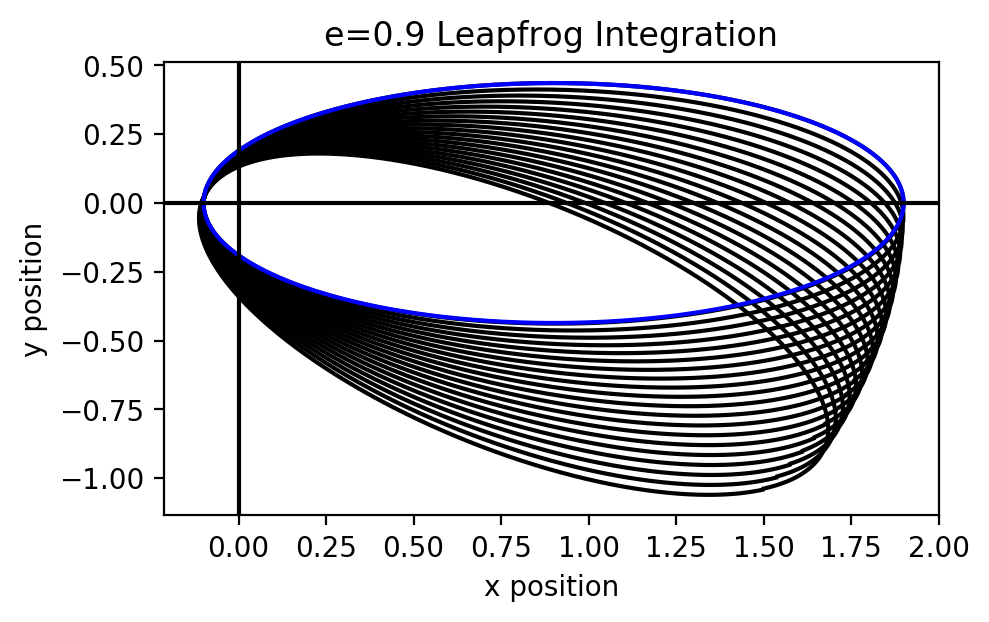

In [3]:
plt.figure(figsize=(5,3),dpi=200)

# Plot the orbits subsampled
steps_per_period = int(np.ceil(period/dt))
fudge = 0
skip = 10
for i in range(20):
    plt.plot(save_pos[skip*i*steps_per_period:(skip*i+1)*steps_per_period,0,0]-
             save_pos[skip*i*steps_per_period:(skip*i+1)*steps_per_period,1,0],
             save_pos[skip*i*steps_per_period:(skip*i+1)*steps_per_period,0,1]-
             save_pos[skip*i*steps_per_period:(skip*i+1)*steps_per_period,1,1],c='k')
    
# Plot the analytic solution
theta = np.linspace(0,2*np.pi,2000)
r = -a*(1-e**2)/(1+e*np.cos(theta))
x_an = r*np.cos(theta)
y_an = r*np.sin(theta)
plt.plot(x_an,y_an,c='b')

plt.axvline(0,c='k')
plt.axhline(0,c='k')
plt.ylabel('y position')
plt.xlabel('x position')
plt.title('e=0.9 Leapfrog Integration')
plt.show()

## 3 Body Problem

In [ ]:
part_pos = np.array([[2,0,0],[0,0,0],[0,2,0]],dtype=np.float64)
part_vel = np.array([[0,1e-4,0],[0,0,0],[0,-1e-4,0]],dtype=np.float64)
part_mass = np.array([100,100,10],dtype=np.float64)
dt = 0.01
num_dt = int(1e8)
t = np.linspace(0,num_dt*dt,num_dt+1)
save_pos = np.zeros((num_dt+1,3,3))
save_vel = np.zeros((num_dt+1,3,3))

integrator.leapfrog_int_nb(part_pos,part_vel,part_mass,dt,num_dt,save_pos,save_vel)

In [ ]:
plt.figure()
cut = int(8e7)
plt.plot(save_pos[:cut:10000,0,0]-save_pos[:cut:10000,0,0],save_pos[:cut:10000,0,1]-save_pos[:cut:10000,0,1])
plt.plot(save_pos[:cut:10000,1,0]-save_pos[:cut:10000,0,0],save_pos[:cut:10000,1,1]-save_pos[:cut:10000,0,1])
plt.plot(save_pos[:cut:10000,2,0]-save_pos[:cut:10000,0,0],save_pos[:cut:10000,2,1]-save_pos[:cut:10000,0,1])
# plt.xlim((-15,20))
# plt.ylim((-5,50))
plt.ylabel('y position')
plt.xlabel('x position')
plt.title('3 Bodies')
plt.show()

In [ ]:
time_step = int(2e5)
length = int(8e7)
sub_samp = int(1e5)
images = []

for i in range(int(length//time_step)):
    if i%10 == 0:
        print(i,time_step*i)
    fig = plt.figure(figsize=(5,5),dpi=100)
    plt_cut = time_step*i
    plt.plot(save_pos[:plt_cut:sub_samp,0,0],save_pos[:plt_cut:sub_samp,0,1])
    plt.plot(save_pos[:plt_cut:sub_samp,1,0],save_pos[:plt_cut:sub_samp,1,1])
    plt.plot(save_pos[:plt_cut:sub_samp,2,0],save_pos[:plt_cut:sub_samp,2,1])
    plt.ylabel('y position')
    plt.xlabel('x position')
    fig.savefig('temp_%i.png'%(i))
    plt.close()
    im = Image.open('temp_%i.png'%(i))
    images.append(im)

print('making the gif')
images[0].save('3b.gif',save_all=True,append_images=images[1:],
              optimize=False, duration=40, loop=0)

print('cleaning up')
for i in range(int(length//time_step)):
    os.remove('temp_%i.png'%(i))

## NFW Integration

In [1]:
import integrator
import numpy as np
import numba
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os

In [3]:
# Start with something simple like circular motion
rho_0 = 0.1
r_scale = 1
G = 0.8962419740798497

dt = 0.01
num_dt = int(5e5)

pos_nfw_array = np.tile(np.zeros(3,dtype=np.float64),(num_dt,1))
save_pos = np.zeros((num_dt+1,3))
save_vel = np.zeros((num_dt+1,3))

rho_0_array = rho_0*np.ones(num_dt,dtype=np.float64)
r_scale_array = r_scale*np.ones(num_dt,dtype=np.float64)

r_init = 20
pos_init = np.array([r_init,0,0],dtype=np.float64)

M_r = 4*np.pi*rho_0*r_scale**3*(np.log((r_scale+r_init)/r_scale)+
                                r_scale/(r_scale+r_init) - 1)
v_r = np.sqrt(G*M_r/r_init)
vel_init = np.array([0,v_r,0],dtype=np.float64)

integrator.leapfrog_int_nfw(pos_init,vel_init,rho_0_array,r_scale_array,pos_nfw_array,dt,save_pos,save_vel)

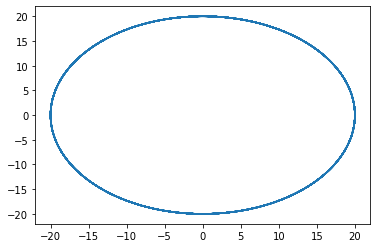

In [4]:
plt.plot(save_pos[:,0],save_pos[:,1])

In [2]:
# Now make the NFW move and see what happens
rho_0 = 0.1
r_scale = 1
G = 0.8962419740798497

dt = 0.01
num_dt = int(1e6)

pos_nfw_array = np.tile(np.zeros(3,dtype=np.float64),(num_dt,1))
for pi, pos in enumerate(pos_nfw_array):
    pos[0] += pi*dt
save_pos = np.zeros((num_dt+1,3))
save_vel = np.zeros((num_dt+1,3))

r_init = 20
pos_init = np.array([r_init,0,0],dtype=np.float64)

rho_0_array = rho_0*np.ones(num_dt,dtype=np.float64)
r_scale_array = r_scale*np.ones(num_dt,dtype=np.float64)

M_r = 4*np.pi*rho_0*r_scale**3*(np.log((r_scale+r_init)/r_scale)+
                                r_scale/(r_scale+r_init) - 1)
v_r = np.sqrt(G*M_r/r_init)
vel_init = np.array([1,v_r,0],dtype=np.float64)
integrator.leapfrog_int_nfw(pos_init,vel_init,rho_0_array,r_scale_array,pos_nfw_array,dt,save_pos,save_vel)

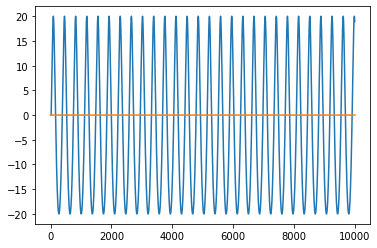

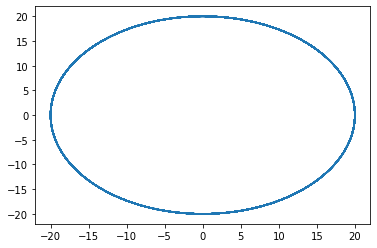

In [3]:
plt.plot(save_pos[:,0],save_pos[:,1])
plt.plot(pos_nfw_array[:,0],pos_nfw_array[:,1])
plt.show()

plt.plot(save_pos[:-1,0]-pos_nfw_array[:,0],save_pos[:-1,1]-pos_nfw_array[:,1])
plt.show()

In [104]:
np.sqrt(G*M_r/r_scale)

2.20562720596458

In [11]:
# Start with something simple like circular motion
rho_0 = 1
r_scale = 1
G = 0.8962419740798497

dt = 0.01
num_dt = int(5e3)

pos_nfw_array = np.tile(np.zeros(3,dtype=np.float64),(num_dt,1))
save_pos = np.zeros((num_dt+1,3))
save_vel = np.zeros((num_dt+1,3))

rho_0_array = rho_0*np.ones(num_dt,dtype=np.float64)
r_scale_array = r_scale*np.ones(num_dt,dtype=np.float64)

r_init = 2
pos_init = np.array([r_init,0,0],dtype=np.float64)

M_r = 4*np.pi*rho_0*r_scale**3*(np.log((r_scale+r_init)/r_scale)+
                                r_scale/(r_scale+r_init) - 1)
print(M_r)
v_r = np.sqrt(G*M_r/r_init)
vel_init = np.array([0,v_r,0],dtype=np.float64)

m_sub = M_r/1e6
m_nfw_array = M_r*np.ones(num_dt,dtype=np.float64)
v_max_nfw_array = np.ones(num_dt,dtype=np.float64)*np.sqrt(G*M_r/r_scale)
rho_vir = 0.01

integrator.leapfrog_int_nfw_f_dyn(pos_init,vel_init,m_sub,rho_0_array,r_scale_array,pos_nfw_array,
                                  m_nfw_array,v_max_nfw_array,rho_vir,dt,save_pos,save_vel)
save_pos2 = np.zeros((num_dt+1,3))
save_vel2 = np.zeros((num_dt+1,3))


pos_init = np.array([r_init,0,0],dtype=np.float64)
vel_init = np.array([0,v_r,0],dtype=np.float64)
m_sub = M_r/1e2
print(m_sub)

integrator.leapfrog_int_nfw_f_dyn(pos_init,vel_init,m_sub,rho_0_array,r_scale_array,pos_nfw_array,
                                  m_nfw_array,v_max_nfw_array,rho_vir,dt,save_pos2,save_vel2)

5.427988771320028
6.24803548254172e-07
0.05427988771320028
0.0007859962884295205


In [14]:
np.sum(dif<0)

0

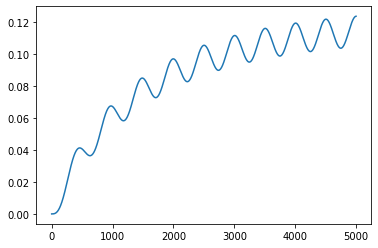

In [12]:
dif = np.sqrt(np.sum(np.square(save_pos),axis=-1))-np.sqrt(np.sum(np.square(save_pos2),axis=-1))
dif /= np.sqrt(np.sum(np.square(save_pos),axis=-1))
plt.plot(dif)

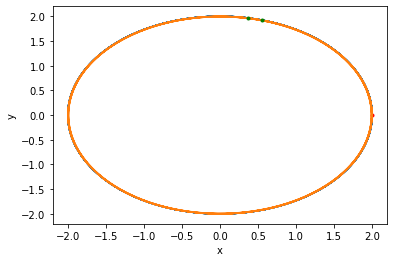

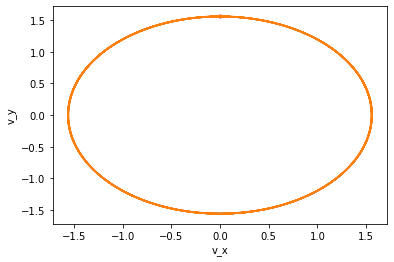

In [10]:
plt.plot(save_pos[0,0],save_pos[0,1],'.r')
plt.plot(save_pos[:,0],save_pos[:,1])
plt.plot(save_pos2[:,0],save_pos2[:,1])
plt.plot(save_pos[-1,0],save_pos[-1,1],'.g')
plt.plot(save_pos2[-1,0],save_pos2[-1,1],'.g')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.plot(save_vel[0,0],save_vel[0,1],'.r')
plt.plot(save_vel[:,0],save_vel[:,1])
plt.plot(save_vel2[:,0],save_vel2[:,1])
plt.xlabel('v_x')
plt.ylabel('v_y')
plt.show()

In [25]:
from galpy.orbit import Orbit
from galpy.potential import NFWPotential

In [64]:
v_r

2.9620222848834104

In [78]:
# Initialize the galpy orbit
v_kick = 1e-1
o=Orbit([r_init,v_kick,v_r,0,0,0])
dt = 0.01
num_dt = int(1e5)
nfw = NFWPotential(a=r_scale,amp=rho_0*G*4*np.pi*r_scale**3)
ts = np.linspace(0,dt*num_dt,num_dt+1)
o.integrate(ts,nfw,method='leapfrog',dt=dt)

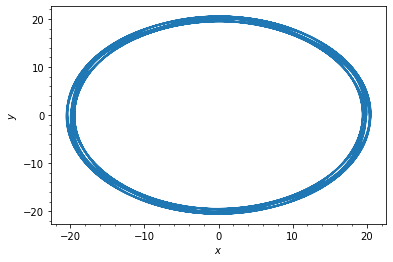

In [79]:
o.plot(d1='x',d2='y')

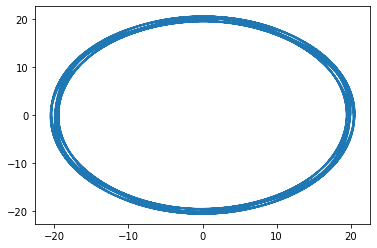

In [80]:
plt.plot(o.x(ts),o.y(ts))

In [87]:
pos_nfw_array = np.tile(np.zeros(3,dtype=np.float64),(num_dt,1))
save_pos = np.zeros((num_dt+1,3))
save_vel = np.zeros((num_dt+1,3))

r_init = 20
pos_init = np.array([r_init,0,0],dtype=np.float64)

M_r = 4*np.pi*rho_0*r_scale**3*(np.log((r_scale+r_init)/r_scale)+
                                r_scale/(r_scale+r_init) - 1)
v_r = np.sqrt(G*M_r/r_init)
vel_init = np.array([v_kick,v_r,0],dtype=np.float64)

integrator.leapfrog_int_nfw(pos_init,vel_init,rho_0,r_scale,pos_nfw_array,dt,save_pos,save_vel)

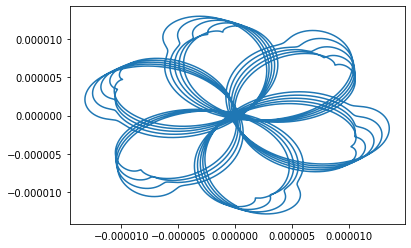

In [88]:
plt.plot(save_pos[:,0]-o.x(ts),save_pos[:,1]-o.y(ts))

In [90]:
v = 1
sigma = 1
x = 1/np.sqrt(2)

In [91]:
np.log(1e4)

9.210340371976184

In [99]:
m_sun = 1.9891e30
m = 1e13*m_sun

r = (m/(4.3*np.pi*200*8.5e-27))**(1/3)

In [101]:
np.sqrt(G*m/r)/1000

373.19253038869056

In [109]:
6.67430e-11/v1/v2*v3

0.8962417726560811

In [107]:
v1 = (400*1e3)**2
v2 = 300*3.086e19
v3 = 1.9891e30*1e13

In [111]:
6.67430e-11/0.8962419740798497

7.446984400448711e-11